## Embedding

In [1]:
# imports
import mace, py3Dmol
from rdkit.Chem import Draw

# view 2D (not needed, just for the better sphinx thumbmails)
def draw_mol(mol, size = (300, 300)):
    '''Returns PIL Image'''
    return Draw.MolToImage(mol, size = size)

# view 3D structures
def view_complex(X, confId = 0):
    '''Shows molecule corresponding to the SMILES'''
    view = py3Dmol.view(width = 360, height = 360)
    view.addModel(X.ToXYZBlock(confId = confId), 'xyz')
    view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.3}})
    view.setBackgroundColor('white')
    view.zoomTo()
    view.show()

### Generation of conformers

If atomic map numbers of donor atoms are correct (no repeats, lies in range [1,6]/[1,4] for OH/SP geometry, etc.), than one can generate 3D atomic coordinates:

In [2]:
# get 3D after initializing complex
ligands = ['[NH2:1]CC[NH2:2]', '[NH2:3]CC[NH2:4]', '[Cl-:5]', '[Cl-:6]']
X = mace.ComplexFromLigands(ligands = ligands, CA = '[Ru+2]', geom = 'OH')
X.AddConformer()
view_complex(X)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

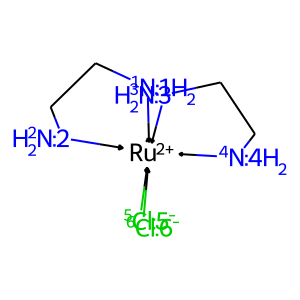

In [3]:
# get thumbnail for sphinx gallery
draw_mol(X.mol)

If the atomic map numbers are set incorrectly, one must first generate possible stereomers (see the "Stereomers generation" section):

In [4]:
# try to get 3D coords without stereo info for CA
ligands = ['[NH2:1]CC[NH2:1]', '[NH2:1]CC[NH2:1]', '[Cl-:1]', '[Cl-:1]']
X1 = mace.ComplexFromLigands(ligands = ligands, CA = '[Ru+2]', geom = 'OH')
try:
    X1.AddConformer()
except Exception as e:
    print(e)

Bad SMILES: isotopic labels are not unique

The initial SMILES contains insufficient or erroneous info
on the positions of the ligands around the central atom
encoded with isotopic labels.

To use 3D generation and other features, first generate
possible stereomers



The main parameters of `Complex.AddConformers` method are number of conformers to generate `numConfs` and minimal RMSD between conformers when they are considered as identical `rmsThresh`:

In [5]:
# get several conformers with rms threshold
ligands = ['C[P:2](C)CCCC[N:3](C)CCCC[P:4](C)C', '[C-:1]#[O+]', '[C-:5]#[O+]', '[C-:6]#[O+]']
X = mace.ComplexFromLigands(ligands = ligands, CA = '[Ru+2]', geom = 'OH')
X.AddConformers(numConfs = 10, rmsThresh = 2.0)
X.GetNumConformers()

4

As one can see, number of generated conformers is less than `numConfs` value due to the filtering of similar conformations.

### Analysing conformers' energies

Analysis of molecular mechanical energies help to identify "good" and "bad" (potentially unsuitable for QM computations) geometries:

In [6]:
# get conf energies
Es = [X.GetConfEnergy(idx) for idx in range(X.GetNumConformers())]
Es

[154.16904500164776,
 153.00520591073658,
 160.57425249049072,
 159.33188783509556]

In [7]:
# find indexes of best/worst conformers
idx_min = X.GetMinEnergyConfId(0)
idx_max = X.GetMinEnergyConfId(X.GetNumConformers() - 1)
idx_min, idx_max

(1, 2)

In [8]:
# view
print('Best conformer:')
view_complex(X, confId = idx_min)
print('Worst conformer:')
view_complex(X, confId = idx_max)

Best conformer:


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Worst conformer:


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

To avoid such inconvenience with detection of low-energy conformers, one can reorder them by energy:

In [9]:
# reorder conformers
X.OrderConfsByEnergy()
Es = [X.GetConfEnergy(idx) for idx in range(X.GetNumConformers())]
Es

[153.00520591073658,
 154.16904500164776,
 159.33188783509556,
 160.57425249049072]

### Filtering conformers

Some chemical problems requires computations of a representative set of conformers, e.g. for an estimation of a conformational free energy. The usual technique to achieve that is conformational sampling, however, there are not many well-parametrized force fields for metal complexes (including those ones in Grimme's xTB). In this case you can use the `Complex.GetRepresentativeConfs` method, which drops high-energy conformers (high MM energy indicates high strain energy and possible errors during embedding) and selects the most diversed set of conformers:

In [10]:
# generate a lot of conformers
X.AddConformers(numConfs = 50, rmsThresh = 1.0)
X.GetNumConformers()

46

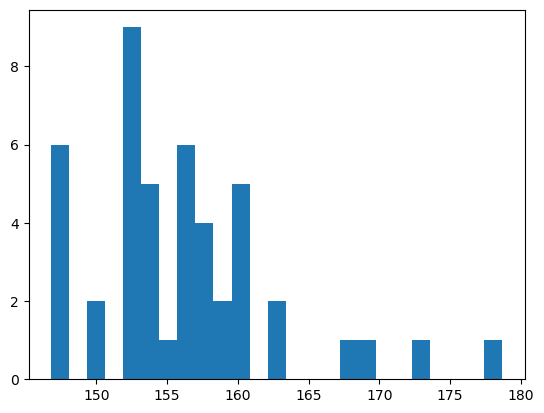

In [11]:
# look at energies
import matplotlib.pyplot as plt
Es = [X.GetConfEnergy(idx) for idx in range(X.GetNumConformers())]
_ = plt.hist(Es, bins = 25)

In [12]:
# get the subset
X.OrderConfsByEnergy()
idxs = X.GetRepresentativeConfs(
    numConfs = 10,          # maximal number of conformations to select;
    dE = 25.0,             # maximal allowed relative MM energy of conformer;
    dropCloseEnergy = True # drops conformers which have a close energy,
                           #     delta < 0.1 , that usually indicates the close geometries.
)
idxs

[0, 9, 22, 23, 24, 30, 40, 41, 42, 43]

In [13]:
# get relative energies
Es_rel = [round(X.GetConfEnergy(idx) - X.GetConfEnergy(idxs[0]), 1) for idx in idxs]
Es_rel

[0.0, 6.2, 8.2, 9.8, 10.0, 11.1, 15.5, 15.6, 21.3, 22.1]

Selected conformers can be saved to multiple xyz-file to be used futher in various computational pipelines:

In [14]:
X.ToMultipleXYZ(path = 'representative_confs.xyz', confIds = idxs)